In [ ]:
# Install PySpark on Deepnote instance
# Takes ~2 minutes
! sudo apt-get update
! sudo mkdir -p /usr/share/man/man1
! sudo apt-get install -y openjdk-11-jdk
! pip install pyspark

Get:1 http://security.debian.org/debian-security buster/updates InRelease [65.4 kB]
Get:2 http://deb.debian.org/debian buster InRelease [122 kB]
Get:3 http://deb.debian.org/debian buster-updates InRelease [51.9 kB]
Get:4 http://security.debian.org/debian-security buster/updates/main amd64 Packages [312 kB]
Get:5 http://deb.debian.org/debian buster/main amd64 Packages [7,906 kB]
Get:6 http://deb.debian.org/debian buster-updates/main amd64 Packages [15.2 kB]
Fetched 8,472 kB in 3s (2,569 kB/s)




The following additional packages will be installed:
  at-spi2-core ca-certificates-java dbus dbus-user-session
  dconf-gsettings-backend dconf-service dmsetup fonts-dejavu-extra
  glib-networking glib-networking-common glib-networking-services
  gsettings-desktop-schemas java-common libapparmor1 libargon2-1 libasound2
  libasound2-data libatk-bridge2.0-0 libatk-wrapper-java
  libatk-wrapper-java-jni libatspi2.0-0 libcap2 libcolord2 libcryptsetup12
  libdconf1 libdevmapper1.02.1 libdrm-amdgpu1 

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import sqlite3

import pyspark
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.classification import (DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LogisticRegression)
from pyspark.ml.evaluation import (BinaryClassificationEvaluator, MulticlassClassificationEvaluator)
from pyspark.mllib.evaluation import (BinaryClassificationMetrics, MulticlassMetrics)
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import lit
import pyspark.sql.functions as F

import warnings
warnings.filterwarnings('ignore')

In [ ]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [ ]:
filepath = 'final_data.csv'

In [ ]:
spark_df = spark.read.csv(filepath,
                     sep=',',
                     inferSchema=True,
                     header=True,)

spark_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- amt: double (nullable = true)
 |-- gender: integer (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- tran_day_of_week: integer (nullable = true)
 |-- tran_day_of_month: integer (nullable = true)
 |-- tran_month_of_year: integer (nullable = true)
 |-- tran_hour_of_day: integer (nullable = true)
 |-- cat_food_dining: integer (nullable = true)
 |-- cat_gas_transport: integer (nullable = true)
 |-- cat_grocery_net: integer (nullable = true)
 |-- cat_grocery_pos: integer (nullable = true)
 |-- cat_health_fitness: integer (nullable = true)
 |-- cat_home: integer (nullable = true)
 |-- cat_kids_pets: integer (nullable = true)
 |-- cat_misc_net: integer (nullable = true)
 |-- cat_misc_pos: integer (nullable = true)
 |-- cat_personal_care: integer (nullable = true)
 |-- cat_shopping_net: integer (nullable = true)
 |-- cat_shopping_pos: integer (nullable = true)
 |-- cat_travel: integer (nullable = tru

In [ ]:
spark_df = spark_df.drop('_c0')

In [ ]:
spark_df.show(10)

+------+------+--------+----+----------------+-----------------+------------------+----------------+---------------+-----------------+---------------+---------------+------------------+--------+-------------+------------+------------+-----------------+----------------+----------------+----------+--------+
|   amt|gender|city_pop| age|tran_day_of_week|tran_day_of_month|tran_month_of_year|tran_hour_of_day|cat_food_dining|cat_gas_transport|cat_grocery_net|cat_grocery_pos|cat_health_fitness|cat_home|cat_kids_pets|cat_misc_net|cat_misc_pos|cat_personal_care|cat_shopping_net|cat_shopping_pos|cat_travel|is_fraud|
+------+------+--------+----+----------------+-----------------+------------------+----------------+---------------+-----------------+---------------+---------------+------------------+--------+-------------+------------+------------+-----------------+----------------+----------------+----------+--------+
|  2.86|     1|  333497|52.0|               6|               21|               

In [ ]:
spark_df.dtypes

[('amt', 'double'),
 ('gender', 'int'),
 ('city_pop', 'int'),
 ('age', 'double'),
 ('tran_day_of_week', 'int'),
 ('tran_day_of_month', 'int'),
 ('tran_month_of_year', 'int'),
 ('tran_hour_of_day', 'int'),
 ('cat_food_dining', 'int'),
 ('cat_gas_transport', 'int'),
 ('cat_grocery_net', 'int'),
 ('cat_grocery_pos', 'int'),
 ('cat_health_fitness', 'int'),
 ('cat_home', 'int'),
 ('cat_kids_pets', 'int'),
 ('cat_misc_net', 'int'),
 ('cat_misc_pos', 'int'),
 ('cat_personal_care', 'int'),
 ('cat_shopping_net', 'int'),
 ('cat_shopping_pos', 'int'),
 ('cat_travel', 'int'),
 ('is_fraud', 'int')]

In [ ]:
spark_df.createOrReplaceTempView('data')

In [ ]:
fraud_counts = spark.sql(r"""SELECT is_fraud, COUNT(*) AS cnt 
                            FROM data
                            GROUP BY is_fraud""")
fraud_counts.show()

+--------+-------+
|is_fraud|    cnt|
+--------+-------+
|       1|   9651|
|       0|1842743|
+--------+-------+



In [ ]:
gender_counts = spark.sql(r"""SELECT CASE when gender = 1 then 'male' 
                                          when gender = 2 then 'female' 
                                          end as gender 
                                          , COUNT(*) AS cnt 
                            FROM data
                            GROUP BY gender""")
gender_counts.show()
# male - 1, female - 2

+------+-------+
|gender|    cnt|
+------+-------+
|  male| 837645|
|female|1014749|
+------+-------+



In [ ]:
gender_amounts = spark.sql(r"""SELECT CASE when gender = 1 then 'male' 
                                           when gender = 2 then 'female' 
                                           end as gender 
                                          , SUM(amt) AS amt 
                            FROM data
                            GROUP BY gender""")
gender_amounts.show()
# male - 1, female - 2

+------+-------------------+
|gender|                amt|
+------+-------------------+
|  male|5.879701363000017E7|
|female|7.098831837999928E7|
+------+-------------------+



In [ ]:
fraud_by_gender_cnt = spark.sql(r"""SELECT CASE when gender = 1 then 'male' 
                                           when gender = 2 then 'female' 
                                           end as gender
                                           , is_fraud
                                           , COUNT(*) AS cnt 
                            FROM data
                            GROUP BY gender, is_fraud""")
fraud_by_gender_cnt.show()
# male - 1, female - 2

+------+--------+-------+
|gender|is_fraud|    cnt|
+------+--------+-------+
|  male|       0| 832893|
|  male|       1|   4752|
|female|       1|   4899|
|female|       0|1009850|
+------+--------+-------+



In [ ]:
fraud_by_gender_amt = spark.sql(r"""SELECT CASE when gender = 1 then 'male' 
                                           when gender = 2 then 'female' 
                                           end as gender
                                           , is_fraud
                                           , sum(amt) AS amt 
                            FROM data
                            GROUP BY gender, is_fraud""")
fraud_by_gender_amt.show()
# male - 1, female - 2

+------+--------+-------------------+
|gender|is_fraud|                amt|
+------+--------+-------------------+
|  male|       0|5.607834692000026E7|
|  male|       1| 2718666.7100000037|
|female|       1|         2402746.58|
|female|       0| 6.85855717999996E7|
+------+--------+-------------------+



In [ ]:
spark_df.show()

+------+------+--------+----+----------------+-----------------+------------------+----------------+---------------+-----------------+---------------+---------------+------------------+--------+-------------+------------+------------+-----------------+----------------+----------------+----------+--------+
|   amt|gender|city_pop| age|tran_day_of_week|tran_day_of_month|tran_month_of_year|tran_hour_of_day|cat_food_dining|cat_gas_transport|cat_grocery_net|cat_grocery_pos|cat_health_fitness|cat_home|cat_kids_pets|cat_misc_net|cat_misc_pos|cat_personal_care|cat_shopping_net|cat_shopping_pos|cat_travel|is_fraud|
+------+------+--------+----+----------------+-----------------+------------------+----------------+---------------+-----------------+---------------+---------------+------------------+--------+-------------+------------+------------+-----------------+----------------+----------------+----------+--------+
|  2.86|     1|  333497|52.0|               6|               21|               

### split data into train, val, and test (stratified)

In [ ]:
fractions = spark_df.select("is_fraud").distinct().withColumn("fraction", lit(0.6)).rdd.collectAsMap()                                                         
train_df = spark_df.stat.sampleBy("is_fraud", fractions, seed = 42)

In [ ]:
test_df = spark_df.subtract(train_df)

In [ ]:
fractions = test_df.select("is_fraud").distinct().withColumn("fraction", lit(0.5)).rdd.collectAsMap()                                                         
val_df = test_df.stat.sampleBy("is_fraud", fractions, seed = 42)

In [ ]:
test_df = test_df.subtract(val_df)

In [ ]:
train_df.groupBy('is_fraud').count().show()

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       1|   5765|
|       0|1106662|
+--------+-------+



In [ ]:
val_df.groupBy('is_fraud').count().show()

+--------+------+
|is_fraud| count|
+--------+------+
|       1|  1961|
|       0|368407|
+--------+------+



In [ ]:
test_df.groupBy('is_fraud').count().show()

+--------+------+
|is_fraud| count|
+--------+------+
|       1|  1924|
|       0|367670|
+--------+------+



### oversample the minority class

In [ ]:
# Implement oversampling method
import pyspark.sql.functions as F

# calculate ratio
major_df = train_df.filter(train_df.is_fraud == 0)
minor_df = train_df.filter(train_df.is_fraud == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))
a = range(ratio)

# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", F.explode(F.array([F.lit(x) for x in a]))).drop('dummy')

# combine both oversampled minority rows and previous majority rows 
train_df_os = major_df.unionAll(oversampled_df)

ratio: 191


In [ ]:
train_df_os.groupby('is_fraud').count().show()

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       0|1106662|
|       1|1101115|
+--------+-------+



### Modeling

In [ ]:
train_df_os.schema.names#[:-1]

['amt',
 'gender',
 'city_pop',
 'age',
 'tran_day_of_week',
 'tran_day_of_month',
 'tran_month_of_year',
 'tran_hour_of_day',
 'cat_food_dining',
 'cat_gas_transport',
 'cat_grocery_net',
 'cat_grocery_pos',
 'cat_health_fitness',
 'cat_home',
 'cat_kids_pets',
 'cat_misc_net',
 'cat_misc_pos',
 'cat_personal_care',
 'cat_shopping_net',
 'cat_shopping_pos',
 'cat_travel',
 'is_fraud']

In [ ]:
# the feature columns
features = train_df_os.schema.names[:-1]

assembler = VectorAssembler(inputCols=features, outputCol='features')

train_pack = assembler.transform(train_df_os)
val_pack = assembler.transform(val_df)
test_pack = assembler.transform(test_df)

In [ ]:
# scaling
minmaxscale = MinMaxScaler(inputCol='features', outputCol='features_scaled')
minmaxscale = minmaxscale.fit(train_pack)

train_pack = minmaxscale.transform(train_pack)
val_pack  = minmaxscale.transform(val_pack)
test_pack  = minmaxscale.transform(test_pack)

In [ ]:
# logistic regression
lr = LogisticRegression(labelCol='is_fraud', 
                        featuresCol='features_scaled',
                        predictionCol='prediction')

lr_model = lr.fit(train_pack)
lr_pred = lr_model.transform(val_pack)

In [ ]:
# Random Forest (depth = 2)
rf = RandomForestClassifier(maxDepth=2, 
                            labelCol='is_fraud',
                            featuresCol='features',
                            predictionCol='prediction')

rf_model = rf.fit(train_pack)
rf_pred = rf_model.transform(val_pack)

In [ ]:
# Gradient Boosted Tree (depth = 2)
gbt = GBTClassifier(maxDepth=2, 
                    labelCol='is_fraud', 
                    featuresCol='features',
                    predictionCol='prediction')

gbt_model = gbt.fit(train_pack)
gbt_pred = gbt_model.transform(val_pack)

In [ ]:
accuracy = MulticlassClassificationEvaluator(labelCol='is_fraud', 
                                             predictionCol='prediction',
                                             metricName='accuracy')

precision = MulticlassClassificationEvaluator(labelCol='is_fraud', 
                                              predictionCol='prediction',
                                              metricName='weightedPrecision')

recall = MulticlassClassificationEvaluator(labelCol='is_fraud', 
                                           predictionCol='prediction',
                                           metricName='weightedRecall')

f1 = MulticlassClassificationEvaluator(labelCol='is_fraud', 
                                       predictionCol='prediction',
                                       metricName='f1')

areaROC = BinaryClassificationEvaluator(labelCol='is_fraud',
                                        rawPredictionCol='prediction',
                                        metricName='areaUnderROC')

areaPR = BinaryClassificationEvaluator(labelCol='is_fraud',
                                       rawPredictionCol='prediction',
                                       metricName='areaUnderPR')

In [ ]:
# the error metrics
metrics = [accuracy, precision, recall, f1, areaROC, areaPR]
metric_labels = ['accuracy', 'precision', 'recall', 'f1', 'areaROC', 'areaPR']

# the predictions from each model
predictions = [lr_pred, rf_pred, gbt_pred]
predict_labels = ['LR', 'RF', 'GBT']

eval_list = list()

# for each model's predictions, calculate error metrics
# and add to a Pandas series
for pred in zip(predict_labels, predictions):
    name = pred[0]
    predict = pred[1]
    
    metric_vals = pd.Series(dict([(x[0], x[1].evaluate(predict)) 
                                 for x in zip(metric_labels, metrics)]),
                            name=name)
    eval_list.append(metric_vals)
    
# combine all the series into a dataframe
eval_df = pd.concat(eval_list, axis=1).T
eval_df = eval_df[metric_labels]
eval_df

,accuracy,precision,recall,f1,areaROC,areaPR
LR,0.887798,0.993480,0.887798,0.935686,0.825670,0.031591
RF,0.967511,0.994033,0.967511,0.979269,0.867006,0.101964
GBT,0.943691,0.994647,0.943691,0.966521,0.929088,0.076570


### Grid Search CV to tune the model

In [ ]:
# Tuning the GradientBoostedTree model
gbt_2 = GBTClassifier(featuresCol='features',
                     labelCol='is_fraud', 
                     predictionCol='prediction')
 
# the pipeline
pipeline = Pipeline(stages=[assembler, gbt_2]) 

# the parameter grid
paramgrid = (ParamGridBuilder().addGrid(gbt_2.maxDepth, [2, 4, 6])
                               .addGrid(gbt_2.stepSize, [0.001, 0.01, 0.1, 1])
# commented out, training takes too much time                               .addGrid(gbt_2.maxBins,  [10, 20, 40])
# commented out, training takes too much time                               .addGrid(gbt_2.maxIter,  [5, 10, 20])
                               .build())

# use f1 score as the evaluation metric for best model 
evaluator = MulticlassClassificationEvaluator(labelCol='is_fraud', 
                                              predictionCol='prediction', 
                                              metricName='f1') 

In [ ]:
# 5 folds CV
crossval = CrossValidator(estimator=pipeline, 
                          estimatorParamMaps=paramgrid, 
                          evaluator=evaluator, 
                          numFolds=5) 

gbt_tuned_model = crossval.fit(train_df_os) 

In [ ]:
# return the best model based on f1 score
best_pipeline = gbt_tuned_model.bestModel

best_gbt_model = best_pipeline.stages[1]

In [ ]:
# number of trees
len(best_gbt_model.trees)

20

In [ ]:
# list some of the trees
best_gbt_model.trees[:10]

[DecisionTreeRegressionModel: uid=dtr_d00ee2f8d590, depth=6, numNodes=77, numFeatures=21,
 DecisionTreeRegressionModel: uid=dtr_6fc90373e3c2, depth=6, numNodes=93, numFeatures=21,
 DecisionTreeRegressionModel: uid=dtr_21971737ea57, depth=6, numNodes=119, numFeatures=21,
 DecisionTreeRegressionModel: uid=dtr_c5b49f68ec04, depth=6, numNodes=125, numFeatures=21,
 DecisionTreeRegressionModel: uid=dtr_881703c9c7a4, depth=6, numNodes=123, numFeatures=21,
 DecisionTreeRegressionModel: uid=dtr_1f148cbd18b4, depth=6, numNodes=125, numFeatures=21,
 DecisionTreeRegressionModel: uid=dtr_f70dc951896b, depth=6, numNodes=125, numFeatures=21,
 DecisionTreeRegressionModel: uid=dtr_35203661a77f, depth=6, numNodes=127, numFeatures=21,
 DecisionTreeRegressionModel: uid=dtr_13249457c086, depth=6, numNodes=127, numFeatures=21,
 DecisionTreeRegressionModel: uid=dtr_1186319263de, depth=6, numNodes=127, numFeatures=21]

In [ ]:
# weights
best_gbt_model.treeWeights[:10]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [ ]:
# extract feature importances
feature_importances = best_gbt_model.featureImportances.toArray()

# extract feature names, except for the predictor
feature_names = train_df_os.columns[:-1]

feature_series = (pd.Series(dict(zip(feature_names, feature_importances)))
                  .sort_values(ascending=True))

feature_series

cat_shopping_pos      0.000913
tran_day_of_week      0.001444
cat_misc_net          0.002595
gender                0.002768
tran_month_of_year    0.002970
cat_kids_pets         0.003873
tran_day_of_month     0.003938
cat_shopping_net      0.005031
cat_health_fitness    0.005158
cat_personal_care     0.008245
cat_food_dining       0.012319
cat_travel            0.014198
cat_misc_pos          0.016998
cat_grocery_pos       0.018039
city_pop              0.019002
cat_grocery_net       0.021318
cat_home              0.023671
age                   0.038161
cat_gas_transport     0.040237
tran_hour_of_day      0.115970
amt                   0.643152
dtype: float64

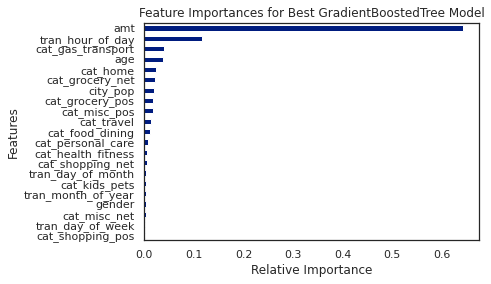

In [ ]:
sns.set_palette('dark')
sns.set_context('notebook')
sns.set_style('white')

ax = feature_series.plot(kind='barh')
_ = ax.set(xlabel='Relative Importance', 
           ylabel='Features', 
           title='Feature Importances for Best GradientBoostedTree Model')

fig = plt.gcf()

### Model testing

In [ ]:
gbt_pred_test = best_pipeline.transform(test_df)

evaluate_model_predictions([gbt_pred_test], ['GBT_GridSearch'])

NameError: name 'evaluate_model_predictions' is not defined

In [ ]:
# the error metrics
metrics = [accuracy, precision, recall, f1, areaROC, areaPR]
metric_labels = ['accuracy', 'precision', 'recall', 'f1', 'areaROC', 'areaPR']

# the predictions from each model
predictions = [gbt_pred_test]
predict_labels = ['GBT']

eval_list = list()

# for each model's predictions, calculate error metrics
# and add to a Pandas series
for pred in zip(predict_labels, predictions):
    name = pred[0]
    predict = pred[1]
    
    metric_vals = pd.Series(dict([(x[0], x[1].evaluate(predict)) 
                                 for x in zip(metric_labels, metrics)]),
                            name=name)
    eval_list.append(metric_vals)
    
# combine all the series into a dataframe
eval_df = pd.concat(eval_list, axis=1).T
eval_df = eval_df[metric_labels]
eval_df

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1ffa185a-4bcd-432d-b0bf-f70e3dc06cbd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>